<a href="https://colab.research.google.com/github/bezhvin/PyData2020-Eindhoven/blob/main/PyData_GAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implemetation of Generative Adversarial Imputation Nets (GAIN) with tensorflow 2.x and Keras


In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow.keras.backend as KB
from sklearn.metrics import mean_squared_error

In [3]:
def plot(samples, strategy):
    fig = plt.figure(figsize = (5,5))
    gs = gridspec.GridSpec(5,5)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28,28))
    fig.suptitle(f'{strategy} imputation')    
    return fig

Reading and normalizing MNIST data


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
Dim = x_train.shape[1] * x_train.shape[2]
x_train=x_train.reshape((x_train.shape[0],Dim))
x_train = x_train / x_train.max()
x_test=x_test.reshape((x_test.shape[0],Dim))
x_test = x_test / x_test.max()
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)



In [5]:
## setting some variables:
p_hint = 0.9 ### The hint probability
p_missing = 0.2 ### missing rate
mb_size= 128 ### mini batch size
Train_No, D = x_train.shape

In [6]:
### defining some functions
def induce_missingness(data, p_missing=p_missing): ### indicung missingness in the data
  new_data= np.copy(data)
  A = np.random.uniform(0., 1., size = [data.shape[0], data.shape[1]])
  B = A < p_missing
  new_data[B] = np.nan
  return new_data

def make_noise_mask_hint(data, p_hint=0.9): ### this function creates auxilary data structures required for GAIN (e.g. hint, mask)
  # noise of the same size as data
  Z = np.random.uniform(0,1,[data.shape[0], data.shape[1]])
  #mask to show what element is missing
  mask = 1. * np.invert(np.isnan(data))
  # hint vector (refer to teh paper)
  A = np.random.uniform(0., 1., size = [data.shape[0], data.shape[1]])
  B = A > (1- p_hint)
  C = 1. * B
  hint = C * mask + (1-C) * 0.5
  return Z, mask, hint, C

In [7]:
### Preparing data ....
x_train_miss = induce_missingness(x_train)
x_test_miss = induce_missingness(x_test)

noise_train, mask_train, hint_train, B_train = make_noise_mask_hint(x_train_miss)
noise_test, mask_test, hint_test, B_test = make_noise_mask_hint(x_test_miss)

In [8]:
### Making generator and discriminator
def make_generator(gen_inp_dim, gen_out_dim):
  generator = Sequential(name='generator')
  generator.add(Dense(units = 256, input_dim=gen_inp_dim, activation=tf.nn.leaky_relu ))
  generator.add(Dense(units = 128, activation=tf.nn.leaky_relu))
  generator.add(Dense(units=gen_out_dim, activation=tf.nn.sigmoid))
  return generator

def make_discriminator(disc_inp_dim, disc_out_dim):
  discriminator = Sequential(name='discriminator')
  discriminator.add(Dense(units = 256, input_dim=disc_inp_dim, activation=tf.nn.leaky_relu ))
  discriminator.add(Dense(units = 128, activation=tf.nn.leaky_relu))
  discriminator.add(Dense(units=disc_out_dim, activation=tf.nn.sigmoid))
  return discriminator

In [9]:
## generator imput:
def make_gen_inp(x,m, z):
  y =  m * x + (1-m) * z 
  return tf.concat([y,m], axis=-1)
## discriminator input
def make_disc_inp(x,m, g, h):
  y =  m * x + (1-m) * g 
  return tf.concat([y,h], axis=-1)

def initialize_models():
  g_in = make_gen_inp(x_train, mask_train, noise_train)
  generator = make_generator(g_in.shape[1],x_train.shape[1])
  g_out = generator(g_in)
  d_in = make_disc_inp(x_train, mask_train, g_out, hint_train)
  discriminator = make_discriminator(d_in.shape[1],hint_train.shape[1])
  return discriminator, generator


g_in = make_gen_inp(x_train, mask_train, noise_train)
g_in_test = make_gen_inp(x_test, mask_test, noise_test)
def calc_mse(generator, data =x_train ,g_in=g_in, mask = mask_train): ## returning MSE
  g_out = generator(g_in)
  return np.mean(((mask * data - mask * g_out)**2)) / np.mean(mask)

In [10]:
# data pipeline from tensorflow data --> https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train,mask_train, noise_train,hint_train, B_train)).repeat(10).shuffle(Train_No).batch(mb_size)

In [11]:
### defining discriminator and generator loss function
D_loss = lambda: -KB.mean((1.-b) * (m * KB.log(discriminator(disc_inp) + 1e-8) + (1.-m) * KB.log(1. - discriminator(disc_inp) + 1e-8))) ## cross entropy loss function for the discriminator
def G_loss(): # as explained in the paper
  g= generator(make_gen_inp(x,m,z))
  d= discriminator(make_disc_inp(x,m,g,h))
  loss1 = -KB.mean((1-b) * ((1-m) * KB.log(d + 1e-8))) / KB.mean(1-m) # discriminator assessment for missing elements
  loss2 =  KB.mean((m * x - m*g)**2) / KB.mean(m) ## MSE for observed elements
  return loss1 + alpha*loss2

In [12]:
discriminator, generator = initialize_models()

In [13]:
theta_D = discriminator.trainable_weights
theta_G = generator.trainable_weights

In [14]:
### Training starts ...
it=0
alpha=10; data=[]
train_mse_error = []; test_mse_error = []
Loss_D=[]; Loss_G=[]; Loss_C=[] ; error_test=[]; error_train=[]
for x, y, m, z,h,b in train_data: ### going over mini batches
  it = it + 1 
  z,m,h,b = tf.dtypes.cast((z,m,h,b), dtype=tf.float32)
  x = tf.image.convert_image_dtype(x, dtype=tf.float32)
  ## making generator input:
  gen_inp = make_gen_inp(x,m,z)
  g = generator(gen_inp)
  ## making discriminator input
  disc_inp = make_disc_inp(x,m,g,h)
  ## train discriminator on the current batch
  Loss_D.append(D_loss().numpy()) ### storing the loss value for monitoring
  D_solver = tf.keras.optimizers.Adam().minimize(loss = D_loss, var_list=theta_D)

  ## train the generator
  Loss_G.append(G_loss().numpy()) ### storing the loss value for monitoring
  G_solver = tf.keras.optimizers.Adam().minimize(loss = G_loss, var_list=theta_G)


  if it % 500 == 0: ### every 500 iteration we check the model perfromance
    err = calc_mse(generator)
    print(f"at iteration {it} training error is {err}")
    train_mse_error.append(err)
    err_test = calc_mse(generator,data=x_test, g_in=g_in_test, mask=mask_test)
    print(f"at iteration {it} test error is {err_test}")
    test_mse_error.append(err_test)
    data.append(generator(tf.expand_dims(g_in[0], axis=0)))
    print(f"--------------")


at iteration 500 training error is 0.04396921390871595
at iteration 500 test error is 0.04386770015552105
--------------
at iteration 1000 training error is 0.03332501221667498
at iteration 1000 test error is 0.03302769964560754
--------------
at iteration 1500 training error is 0.028360814101314625
at iteration 1500 test error is 0.028169835649015706
--------------
at iteration 2000 training error is 0.026583433178056906
at iteration 2000 test error is 0.026287178272569923
--------------
at iteration 2500 training error is 0.02431254048007444
at iteration 2500 test error is 0.023921343522017503
--------------
at iteration 3000 training error is 0.023241498182528735
at iteration 3000 test error is 0.023117677957312927
--------------
at iteration 3500 training error is 0.021142675582625923
at iteration 3500 test error is 0.020984447941134667
--------------
at iteration 4000 training error is 0.021380203284318527
at iteration 4000 test error is 0.02126723520019411
--------------
at itera

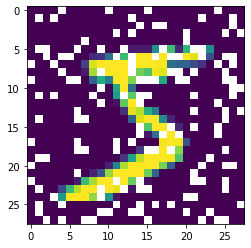

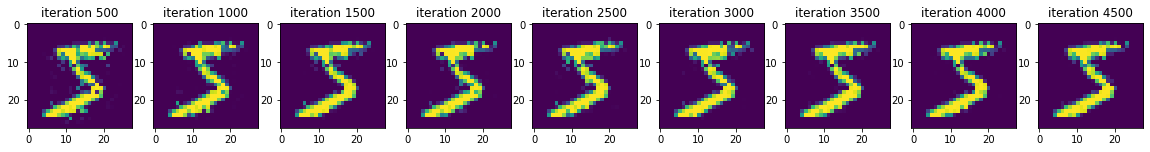

In [20]:
### visualizing the imputation (done by the generator) for some iterations
ax = plt.imshow(np.reshape(x_train_miss[0],(28,28)))
fig, ax = plt.subplots(1,9, figsize=(20,10))
for i , j in enumerate(range(0,len(data))):
  image = mask_train[0] * x_train[0] + (1-mask_train[0]) * data[j]
  image = np.reshape(image,(28,28))
  ax[i].imshow(image)
  ax[i].set_title(f'iteration {j*500 + 500}')

MSE for test data : 0.02113920404913997


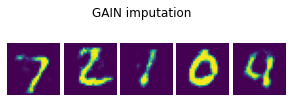

In [21]:
# Plotting the output of generator, NOTE that in practice only missing pixels are taken from this output
x_test_imputed = generator(g_in_test) 
print(f"MSE for test data : {mean_squared_error(x_test_imputed, x_test)}")
fig = plot(x_test_imputed.numpy()[0:5], f'GAIN') ## plotting 5 images after imputation